# Start of actual analysis

Previous Paper: https://pubmed.ncbi.nlm.nih.gov/30334800/ 

used similar dataset, LSTM + 1d-AX + softmax

1d-AX: kinda like windowed mean in A2



In [2]:
import biosig
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, sosfreqz 

#Xuanyu
data_path = './BCICIV_2b_gdf/'#the folder where all raw data files live

#Can
#data_path = '/Users/canliu/COGS 189/Project'

train_portion = 0.7 #the portion of training data among all the raw data files

# from the data description document
event_start = 4 #the start time point (sec) of imagery for each trial
event_end = 7 #the end time point (sec) of imagery for each trial
bsl_start = 0 #the start time point (sec) of baseline for each trial
bsl_end = 2 #the end time point (sec) of baseline for each trial

files = [os.path.join(data_path, f) for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
files = [f for f in files if f[-5]=='T']
# for testing purposes only
train_files = files[:5]

# train_files = train_files[:int(len(files)*train_portion)]

## Define functions

In [3]:
def time_ind_conversion(sr, t):
    """
    Convert time in second to the index in the signal array
    """
    return int(np.round(sr*t))


# from A1
def butter_bandpass(lowcut, highcut, fs, order = 2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
        sos = butter_bandpass(lowcut, highcut, fs, order = order)
        y = sosfiltfilt(sos, data)
        return y
    
    
def populate_data(files, event_start, event_end, bsl_start, bsl_end):
    """
    populate and pre-process (without filtering) data for training the model
    
    input:
        files: list of file paths to the raw data files
        event_start: the start time point (sec) of imagery for each trial
        event_end: the end time point (sec) of imagery for each trial
        bsl_start: the start time point (sec) of baseline for each trial
        bsl_end: the end time point (sec) of baseline for each trial
        
    output:
        data: list of eeg signal segments for each imagery 
        label: list of labels for each segment
    
    """
    labels = []
    data = []
    for i in files:
        HDR = json.loads(biosig.header(i))
        sr  = HDR['Samplingrate']
        events = pd.json_normalize(HDR['EVENT'])
        mi_events = events[events.Description.apply(lambda x: 'class' in x)]
        all_data = biosig.data(i).T
        
        for j in mi_events.index:
            t_start = time_ind_conversion(sr, events.POS[j-1]+event_start)
            t_end = time_ind_conversion(sr, events.POS[j-1]+event_end)
            #only use the EEG channels to prevent the model learning EOG patterns
            seg = all_data[:3, t_start:t_end]
            #calculate baseline and trial mean
            t_bsl_start = time_ind_conversion(sr, events.POS[j-1]+bsl_start)
            t_bsl_end = time_ind_conversion(sr, events.POS[j-1]+bsl_end)
            bsl_sig = all_data[:3, t_bsl_start:t_bsl_end]
            bsl = np.nanmean(bsl_sig, 1)
            trial_mean = np.nanmean(seg, 1)
            #preprocess the data by subtract baseline and the trial mean
            seg_after = (seg.T - bsl - trial_mean).T
            
            data.append(seg_after)
            labels.append(mi_events.Description[j])
    return data, labels

def populate_filt_data(files, event_start, event_end, bsl_start, bsl_end, lowcut=7, highcut=30):
    """
    populate and pre-process data for training the model
    
    "It is noted in the literature that while performing any motor imagery tasks, 
    two major frequency band of EEG spectrum i.e mu (7-12 Hz) as well as beta (12-30 Hz) 
    bands are actively involved."
    
    input:
        files: list of file paths to the raw data files
        event_start: the start time point (sec) of imagery for each trial
        event_end: the end time point (sec) of imagery for each trial
        bsl_start: the start time point (sec) of baseline for each trial
        bsl_end: the end time point (sec) of baseline for each trial
        lowcut: lower end of the bandpass filter, default=7Hz
        highcut: higher end of the bandpass filter, default=30Hz
        
    output:
        data: list of eeg signal segments for each imagery 
        label: list of labels for each segment
    
    """
    labels = []
    data = []
    for i in files:
        HDR = json.loads(biosig.header(i))
        sr  = HDR['Samplingrate']
        events = pd.json_normalize(HDR['EVENT'])
        mi_events = events[events.Description.apply(lambda x: 'class' in x)]
        all_data = biosig.data(i).T
        
        for j in mi_events.index:
            t_start = time_ind_conversion(sr, events.POS[j-1]+event_start)
            t_end = time_ind_conversion(sr, events.POS[j-1]+event_end)
            #only use the EEG channels to prevent the model learning EOG patterns
            seg = all_data[:3, t_start:t_end]
            #calculate baseline and trial mean
            t_bsl_start = time_ind_conversion(sr, events.POS[j-1]+bsl_start)
            t_bsl_end = time_ind_conversion(sr, events.POS[j-1]+bsl_end)
            bsl_sig = all_data[:3, t_bsl_start:t_bsl_end]
            bsl = np.nanmean(bsl_sig, 1)
            trial_mean = np.nanmean(seg, 1)
            #preprocess the data by subtract baseline and the trial mean
            seg_after = butter_bandpass_filter((seg.T - bsl - trial_mean).T, lowcut=lowcut, highcut=highcut, fs=sr)
            
            data.append(seg_after)
            labels.append(mi_events.Description[j])
    return data, labels

def populate_diff_Cz_data(files, event_start, event_end, bsl_start, bsl_end, lowcut=7, highcut=30):
    labels = []
    data = []
    for i in files:
        HDR = json.loads(biosig.header(i))
        sr  = HDR['Samplingrate']
        events = pd.json_normalize(HDR['EVENT'])
        mi_events = events[events.Description.apply(lambda x: 'class' in x)]
        all_data = biosig.data(i).T
        
        for j in mi_events.index:
            t_start = time_ind_conversion(sr, events.POS[j-1]+event_start)
            t_end = time_ind_conversion(sr, events.POS[j-1]+event_end)
            #only use the EEG channels to prevent the model learning EOG patterns
            seg = all_data[:3, t_start:t_end]
            seg_after = butter_bandpass_filter(seg, lowcut=lowcut, highcut=highcut, fs=sr)
            #calculate C3-Cz and C4-Cz
            seg_diff = np.subtract(seg_after, seg_after[1,:])[[0, 2], :]
            data.append(seg_diff)
            labels.append(mi_events.Description[j])
    return data, labels

def populate_diff_LR_data(files, event_start, event_end, bsl_start, bsl_end, lowcut=7, highcut=30):
    labels = []
    data = []
    for i in files:
        HDR = json.loads(biosig.header(i))
        sr  = HDR['Samplingrate']
        events = pd.json_normalize(HDR['EVENT'])
        mi_events = events[events.Description.apply(lambda x: 'class' in x)]
        all_data = biosig.data(i).T
        
        for j in mi_events.index:
            t_start = time_ind_conversion(sr, events.POS[j-1]+event_start)
            t_end = time_ind_conversion(sr, events.POS[j-1]+event_end)
            #only use the EEG channels to prevent the model learning EOG patterns
            seg = all_data[:3, t_start:t_end]
            seg_after = butter_bandpass_filter(seg, lowcut=lowcut, highcut=highcut, fs=sr)
            #calculate C3-C4 and C4-C3
            seg_diff = np.vstack([np.subtract(seg_after[0, :], seg_after[2, :]), 
                                  np.subtract(seg_after[2, :], seg_after[0, :])])
            
            data.append(seg_diff)
            labels.append(mi_events.Description[j])
    return data, labels

def reshape_data(data, label):
    x = np.dstack(data)
    x = x.reshape(x.shape[2], x.shape[1], x.shape[0])
    lb = preprocessing.LabelBinarizer()
    y = lb.fit_transform(label)
    return x, y


## Build the model

In [210]:
import scipy.io
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Conv1D, MaxPooling1D
from keras.optimizers import SGD, Nadam, Adam, RMSprop
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.decomposition import FastICA

from mne.decoding import CSP
from mne import Epochs
from mne.preprocessing import ICA

from scipy.fft import fft, fftfreq

## ICA + FFT + hybrid NN

In [215]:
train_data, train_label = populate_data(train_files, event_start, event_end, bsl_start, bsl_end)
data, label = reshape_data(train_data, train_label)
ica = FastICA()  # we want *all* the components
all_c3 = data[:,:,0]
np.isnan(all_c3).sum()
#components = ica.fit_transform(data[:,:,0])

0

In [ ]:
data_fft = fft(data, axis=1)
train_x_fft, test_x_fft, train_y_fft, test_y_fft = train_test_split(data_fft, label_cz, test_size=0.2, random_state=42)


## FFT + hybrid NN (CNN and LSTM) (bandpass filter)

In [176]:
train_data_cz, train_label_cz = populate_filt_data(train_files, event_start, event_end, bsl_start, bsl_end)
data_cz, label_cz = reshape_data(train_data_cz, train_label_cz)
data_fft = fft(data_cz, axis=1)
train_x_fft, test_x_fft, train_y_fft, test_y_fft = train_test_split(data_fft, label_cz, test_size=0.2, random_state=42)


In [199]:
def create_model(filters=256, pool_size=4, units=64, dropout=0.1, optim='adam'):
    model=Sequential()
    model.add(Conv1D(filters=filters, kernel_size=5, activation = 'relu', input_shape = (750, 3)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model
estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [204]:
param_grid = {
    'filters':[128, 256, 512],
    'pool_size': [4, 16, 64],
    'units': [16, 32, 64],
    'dropout': [0.2, 0.1, 0],
    'optim':['RMSprop', 'Adam','sgd']
}
kfold_splits = 3
grid = GridSearchCV(estimator=estimator,  
                    n_jobs=-1, 
                    verbose=1,
                    return_train_score=True,
                    cv=kfold_splits,  #StratifiedKFold(n_splits=kfold_splits, shuffle=True)
                    param_grid=param_grid)

grid_result = grid.fit(train_x_fft, train_y_fft)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.2min
/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 23.1min finished


18/18 [==============================] - 3s 33ms/step - loss: 0.7447 - accuracy: 0.5024
Best: 0.555556 using {'dropout': 0, 'filters': 128, 'optim': 'RMSprop', 'pool_size': 16, 'units': 64}


In [208]:
model = create_model(filters=grid_result.best_params_['filters'], 
                     optim=grid_result.best_params_['optim'], 
                     pool_size=grid_result.best_params_['pool_size'], 
                     units=grid_result.best_params_['units'],
                     dropout=grid_result.best_params_['dropout']
                    )
model.fit(train_x_fft, train_y_fft, epochs=20, batch_size=50)
model.evaluate(test_x_fft, test_y_fft)

Epoch 1/20
12/12 [==============================] - 3s 56ms/step - loss: 0.6983 - accuracy: 0.5435
Epoch 2/20
12/12 [==============================] - 1s 57ms/step - loss: 0.6833 - accuracy: 0.5633
Epoch 3/20
12/12 [==============================] - 1s 62ms/step - loss: 0.6865 - accuracy: 0.5151
Epoch 4/20
12/12 [==============================] - 1s 56ms/step - loss: 0.6826 - accuracy: 0.5465
Epoch 5/20
12/12 [==============================] - 1s 59ms/step - loss: 0.6604 - accuracy: 0.6030
Epoch 6/20
12/12 [==============================] - 1s 60ms/step - loss: 0.6581 - accuracy: 0.6039
Epoch 7/20
12/12 [==============================] - 1s 72ms/step - loss: 0.6371 - accuracy: 0.6577
Epoch 8/20
12/12 [==============================] - 1s 85ms/step - loss: 0.6139 - accuracy: 0.6933
Epoch 9/20
12/12 [==============================] - 1s 70ms/step - loss: 0.6249 - accuracy: 0.6337
Epoch 10/20
12/12 [==============================] - 1s 60ms/step - loss: 0.5928 - accuracy: 0.7317
Epoch 11/

[0.7960277795791626, 0.4861111044883728]

## CSP Approach

In [137]:
train_data, train_label = populate_filt_data(train_files, event_start, event_end, bsl_start, bsl_end)
data, label = reshape_data(train_data, train_label)
train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.2, random_state=42)
csp = CSP(n_components=4, rank={'eeg':3}, transform_into = 'csp_space')
x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                          np.squeeze(train_y))
x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                               np.squeeze(test_y))

Computing rank from data with rank={'eeg': 3}
    Using tolerance 0.8 (2.2e-16 eps * 3 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.


In [138]:
x_new.shape

(576, 3, 750)

In [139]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(750, 3)))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(5))
model.add(Dense(2, activation='softmax'))
model.summary()
optim = Nadam(lr=0.001)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model.fit(x_new.reshape(x_new.shape[0],x_new.shape[2], x_new.shape[1]) , train_y_cz, epochs=50, batch_size=100)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 750, 20)           1920      
_________________________________________________________________
lstm_31 (LSTM)               (None, 750, 10)           1240      
_________________________________________________________________
lstm_32 (LSTM)               (None, 5)                 320       
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 12        
Total params: 3,492
Trainable params: 3,492
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
6/6 [==============================] - 12s 918ms/step - loss: 0.6927 - accuracy: 0.5115
Epoch 2/50
6/6 [==============================] - 4s 616ms/step - loss: 0.6922 - accuracy: 0.5167
Epoch 3/50
6/6 [==============================] - 3s

In [140]:
score, acc = model.evaluate(x_new_test.reshape(x_new_test.shape[0],x_new_test.shape[2], x_new_test.shape[1]),
                            test_y, verbose = 2, batch_size=100
                           )
print(score, acc)

2/2 - 2s - loss: 0.7999 - accuracy: 0.3889
0.7998559474945068 0.3888888955116272


### CSP-LDA baseline model

In [141]:
csp = CSP(n_components=4, rank={'eeg':3})
x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                          np.squeeze(train_y))
x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                               np.squeeze(test_y))
lda = LinearDiscriminantAnalysis(solver = 'lsqr')
lda.fit(x_new, train_y)
lda.score(x_new_test, test_y)

Computing rank from data with rank={'eeg': 3}
    Using tolerance 0.8 (2.2e-16 eps * 3 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6041666666666666

## Train model on diff_Cz data


In [120]:
train_data_cz, train_label_cz = populate_diff_Cz_data(train_files, event_start, event_end, bsl_start, bsl_end)
data_cz, label_cz = reshape_data(train_data_cz, train_label_cz)
train_x_cz, test_x_cz, train_y_cz, test_y_cz = train_test_split(data_cz, label_cz, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(750, 2)))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(5))
model.add(Dense(2, activation='softmax'))
model.summary()
optim = Nadam(lr=0.001)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model.fit(train_x_cz, train_y_cz, epochs=50, batch_size=100)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 750, 20)           1840      
_________________________________________________________________
lstm_25 (LSTM)               (None, 750, 10)           1240      
_________________________________________________________________
lstm_26 (LSTM)               (None, 5)                 320       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 12        
Total params: 3,412
Trainable params: 3,412
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
6/6 [==============================] - 10s 651ms/step - loss: 0.6968 - accuracy: 0.4864
Epoch 2/50
6/6 [==============================] - 3s 546ms/step - loss: 0.6959 - accuracy: 0.4822
Epoch 3/50
6/6 [==============================] - 3s 

In [121]:
score, acc = model.evaluate(test_x_cz,test_y_cz, verbose = 2, batch_size=100)
print(score, acc)

2/2 - 1s - loss: 0.7235 - accuracy: 0.5347
0.7235018014907837 0.5347222089767456


## Train model on diff_LR data

In [45]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(750, 2)))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(5))
model.add(Dense(2, activation='softmax'))
model.summary()

train_data_lr, train_label_lr = populate_diff_LR_data(train_files, event_start, event_end, bsl_start, bsl_end)
data_lr, label_lr = reshape_data(train_data_lr, train_label_lr)
train_x_lr, test_x_lr, train_y_lr, test_y_lr = train_test_split(data_lr, label_lr, test_size=0.2, random_state=42)
optim = Nadam(lr=0.001)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model.fit(train_x_lr, train_y_lr, epochs=20, batch_size=100)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 750, 20)           1840      
_________________________________________________________________
lstm_10 (LSTM)               (None, 750, 10)           1240      
_________________________________________________________________
lstm_11 (LSTM)               (None, 5)                 320       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 12        
Total params: 3,412
Trainable params: 3,412
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
6/6 [==============================] - 8s 584ms/step - loss: 0.6991 - accuracy: 0.5005
Epoch 2/20
6/6 [==============================] - 4s 629ms/step - loss: 0.6942 - accuracy: 0.4844
Epoch 3/20
6/6 [==============================] - 3s 5

# Questions for check point 1

1. Remove EOG artifact: Needed? How?
    
2. Another tangent: feasible to include EOG information in the classification? Individual variation too high?
    
3. CSP? Restricted by the number of channels?
    
4. Difference not distinct between averaged signals
    
5. Amplitude much smaller after averaging, also noisier
    
6. preprocesing data: does order matter (DC offset -> filtfilt -> baseline correct); what else needed?


compute C3-C4, C4-C3, or diff with Cz, then bandpass 7-30Hz
take the log of the power (normally distributed)

diff more distinct in freq space

EOG artifact:

ICA (http://www.cogsci.ucsd.edu/academicPubs/igorodni/eog-filtering.pdf)

subtract EOG from EEG? **find code**

# Testing garbage place

### Compare after CSP

(-6, 5)

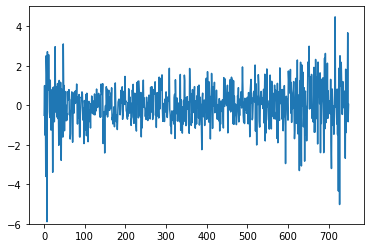

In [104]:
# right imagery C3
plt.plot(np.squeeze(x_new[3,0,:]) - np.squeeze(x_new[3,1,:]))
plt.ylim([-6, 5])

(-6, 5)

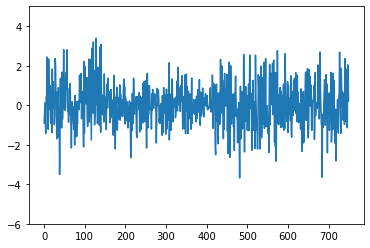

In [105]:
# left imagery C3
plt.plot(np.squeeze(x_new[0,0,:]) - np.squeeze(x_new[0,1,:]))
plt.ylim([-6, 5])

(-5, 5)

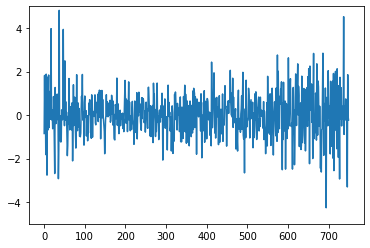

In [108]:
# right imagery C4
plt.plot(np.squeeze(x_new[3,2,:]) - np.squeeze(x_new[3,1,:]))
plt.ylim([-5, 5])

(-5, 5)

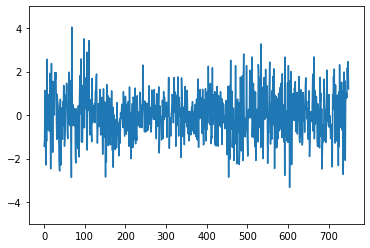

In [109]:
# left imagery C4
plt.plot(np.squeeze(x_new[0,2,:]) - np.squeeze(x_new[0,1,:]))
plt.ylim([-5, 5])

## Train model on filtered data

In [42]:
train_data_filt, train_label_filt = populate_filt_data(train_files, event_start, event_end, bsl_start, bsl_end)
data_filt, label_filt = reshape_data(train_data_filt, train_label_filt)
train_x_filt, test_x_filt, train_y_filt, test_y_filt = train_test_split(data_filt, label_filt, test_size=0.2, random_state=42)

In [43]:
model.fit(train_x_filt, train_y_filt, epochs=20, batch_size=100)

Epoch 1/20
6/6 [==============================] - 3s 529ms/step - loss: 0.6828 - accuracy: 0.5486
Epoch 2/20
6/6 [==============================] - 3s 515ms/step - loss: 0.6784 - accuracy: 0.5694
Epoch 3/20
6/6 [==============================] - 3s 506ms/step - loss: 0.6744 - accuracy: 0.5920
Epoch 4/20
6/6 [==============================] - 3s 579ms/step - loss: 0.6696 - accuracy: 0.5781
Epoch 5/20
6/6 [==============================] - 3s 501ms/step - loss: 0.6655 - accuracy: 0.5938
Epoch 6/20
6/6 [==============================] - 3s 518ms/step - loss: 0.6611 - accuracy: 0.5990
Epoch 7/20
6/6 [==============================] - 3s 541ms/step - loss: 0.6573 - accuracy: 0.6146
Epoch 8/20
6/6 [==============================] - 3s 520ms/step - loss: 0.6522 - accuracy: 0.6163
Epoch 9/20
6/6 [==============================] - 3s 519ms/step - loss: 0.6467 - accuracy: 0.6215
Epoch 10/20
6/6 [==============================] - 3s 518ms/step - loss: 0.6456 - accuracy: 0.6354
Epoch 11/20
6/6 [==

In [44]:
cond1_ind_filt = np.where(train_y_filt==[0])[0]
cond2_ind_filt = np.where(train_y_filt==[1])[0]
cond1_avg_filt = np.mean(train_x_filt[cond1_ind_filt, :,:], axis=0)
cond2_avg_filt = np.mean(train_x_filt[cond2_ind_filt, :,:], axis=0)

In [45]:
len(cond1_ind_filt), len(cond2_ind_filt)

(289, 287)

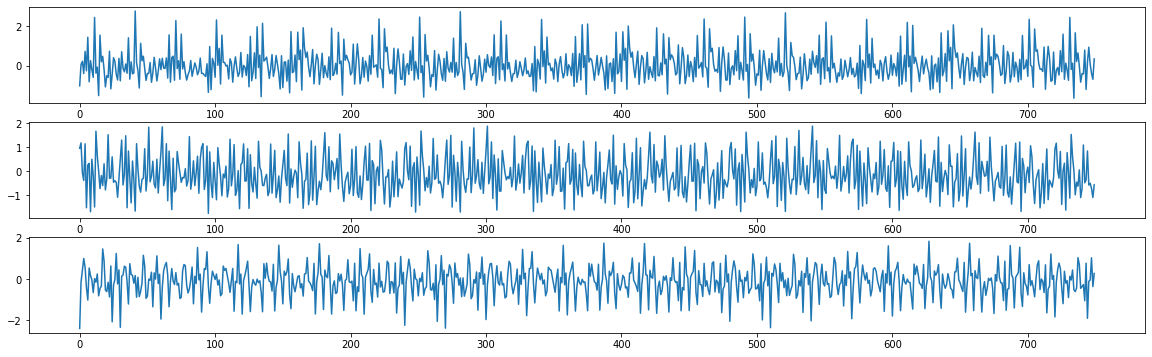

In [46]:
# why blank spot? Use csp?
plt.figure(figsize=(20,6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(cond1_avg_filt[:,i])

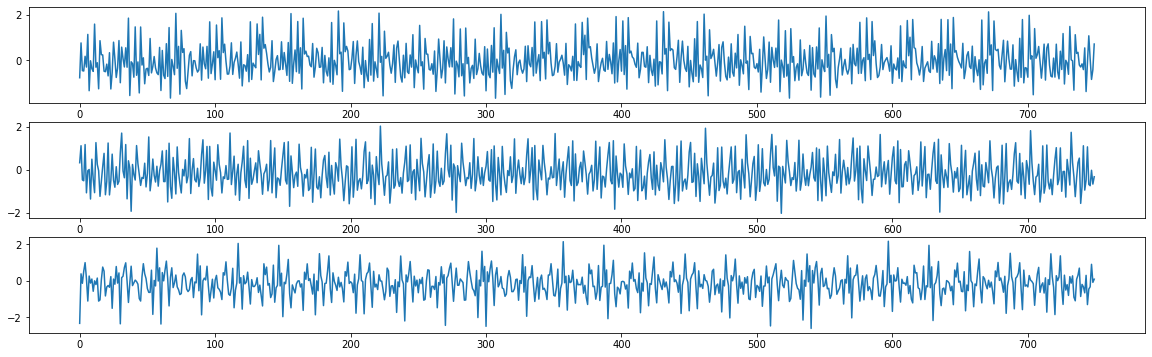

In [47]:
plt.figure(figsize=(20,6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(cond2_avg_filt[:,i])

In [48]:
import biosig
import json
import numpy as np


In [40]:
HDR=json.loads(biosig.header('BCICIV_2b_gdf/B0101T.gdf'))

In [ ]:
HDR.keys()

In [41]:
sr  = HDR['Samplingrate']
sr

250.0

In [ ]:
HDR['CHANNEL']

In [ ]:
import pandas as pd
events = pd.json_normalize(HDR['EVENT'])
events[:10]

In [ ]:
data=biosig.data('BCICIV_2b_gdf/B0101T.gdf').T
data.shape

In [ ]:
import numpy as np
def time_ind_conversion(sr, t):
    return int(np.round(sr*t))

In [ ]:
t_start = time_ind_conversion(sr, events.POS[8]+4)
t_end = time_ind_conversion(sr, events.POS[8]+7)
left_test = data[:,t_start:t_end]
left_test.shape

In [ ]:
import matplotlib.pyplot as plt
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(left_test[i, :])
    

In [ ]:
t_start = time_ind_conversion(sr, events.POS[10]+4)
t_end = time_ind_conversion(sr, events.POS[10]+7)
right_test = data[:,t_start:t_end]
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(right_test[i, :])

## High pass approach

It is noted in the literature that while performing any motor imagery tasks, two major frequency band of EEG spectrum i.e mu (7-12 Hz) as well as beta (12-30 Hz) bands are actively involved.

In [ ]:
# from A1
from scipy.signal import butter, sosfiltfilt, sosfreqz 

def butter_bandpass(lowcut, highcut, fs, order = 2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
        sos = butter_bandpass(lowcut, highcut, fs, order = order)
        y = sosfiltfilt(sos, data)
        return y

In [ ]:
lowcut = 0.1
highcut= 30
left_filtered = butter_bandpass_filter(left_test, lowcut, highcut, sr)
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(left_filtered[i,:])

In [ ]:
right_filtered = butter_bandpass_filter(right_test, lowcut, highcut, sr)
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(right_filtered[i,:])

## FFT approach

In [ ]:
from scipy.fft import fft, fftfreq
N = left_filtered.shape[1]
T = 1/sr
for i in range(6):
    yf = fft(left_test[i,:])
    xf = fftfreq(N, T)[:N//2]
    plt.subplot(6, 1, i+1)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.xticks(rotation=30)
    plt.show()


In [ ]:
N = right_filtered.shape[1]
T = 1/sr
for i in range(6):
    yf = fft(right_test[i,:])
    xf = fftfreq(N, T)[:N//2]
    plt.subplot(6, 1, i+1)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.xticks(rotation=30)
    plt.show()
